model created

model compiled


Epoch 1/3
1184/1205 [============================>.] - ETA: 0s - loss: 109.4977

C:\Users\I054267\AppData\Local\Continuum\miniconda3\envs\carnd-term1_new_tf\lib\site-packages\keras\engine\training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


1216/1205 [==============================] - 21s - loss: 106.6178 - val_loss: 0.0510
Epoch 2/3
1216/1205 [==============================] - 21s - loss: 0.0458 - val_loss: 0.0434
Epoch 3/3
1216/1205 [==============================] - 21s - loss: 0.0375 - val_loss: 0.0427

model trained
Best model so far. Model saved.


model compiled



Epoch 1/3
1216/1205 [==============================] - 22s - loss: 0.0837 - val_loss: 0.0518
Epoch 2/3
1216/1205 [==============================] - 21s - loss: 0.0458 - val_loss: 0.0434
Epoch 3/3
1216/1205 [==============================] - 26s - loss: 0.0375 - val_loss: 0.0427

model trained

model compiled



Epoch 1/3
1216/1205 [==============================] - 25s - loss: 0.0409 - val_loss: 0.0511
Epoch 2/3
1216/1205 [==============================] - 21s - loss: 0.0458 - val_loss: 0.0453
Epoch 3/3
1216/1205 [==============================] - 21s - loss: 0.0375 - val_loss: 0.0425

model trained
Best model so far. Model saved.




Result list (sorted by validation accuracy)
learning rate=7.43e-03, decay_rate=0.9, batch size=32, train loss=0.037, validation loss=0.042
learning rate=7.43e-03, decay_rate=0.05, batch size=32, train loss=0.037, validation loss=0.043
learning rate=7.43e-03, decay_rate=0.1, batch size=32, train loss=0.037, validation loss=0.043


Best model saved


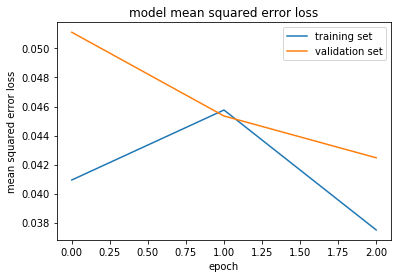

In [7]:
import csv
import cv2
from scipy import ndimage
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO) #logging.INFO logging.DEBUG
if logger.handlers == []:
    ch = logging.StreamHandler()
    logger.addHandler(ch)

############################################################################
# Data generator for data loading and data augmentation
############################################################################
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Load training data (image file name + steering) from csv file
samples = []
with open('./data/data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# Split 20% data as validation samples
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# Define data generator
def generator(samples, batch_size=32, is_training=False):
    
    num_samples = len(samples)
    correction = 0.2
    
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                for i in range(3):
                    try:
                        # Load image and steering angle
                        name = './data/data/IMG/'+batch_sample[i].split('/')[-1]
                        image = ndimage.imread(name)    # Read image in BGR format
                        angle = float(batch_sample[3])
                        if i == 1:    # Left camera image steering correction
                            angle += correction 
                        elif i == 2:  # Right camera image steering correction
                            angle -= correction
                        images.append(image)
                        angles.append(angle)
                        
                        # Data augmentation by flipping if in training mode
                        if is_training:
                           images.append(cv2.flip(image, 1))
                           angles.append(angle * -1.0)
                    except Exception as e:
                        logger.debug("")
                        logger.debug(name)
                        logger.debug(str(e))
                        logger.debug("")

            X_train = np.array(images)
            y_train = np.array(angles)
            
            for offset in range(0, len(X_train), batch_size):
                batch_X = X_train[offset:offset+batch_size]
                batch_y = y_train[offset:offset+batch_size]
                yield shuffle(batch_X, batch_y)

############################################################################
# Create, train, and save model
############################################################################
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Convolution2D
from keras import optimizers
import matplotlib.pyplot as plt

# Hyperparameters
learning_rates = 10 ** np.random.uniform(-3, -1, 10)
decay_rates = 10 ** np.random.uniform(-3, -1, 10)
batch_sizes = [32, 64, 128]  
num_epoch = 5           

# model and history object of various hyperparameters combinations
hyperparameter_dict = {}
best_model = None
best_model_history = None

# Create NVIDIA model
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70, 25), (0,0))))
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
logger.info('model created')

# Since steering will be the only output, this becomes a regression problem,
# therefore mse(mean_squared_error) loss function is chosen
for lr in learning_rates:
    for dr in decay_rates:
        for bs in batch_sizes:
            # Compile model with selected loss function and optimizer
            adam = optimizers.Adam(lr=lr, decay=dr)
            model.compile(loss='mse', optimizer=adam)
            logger.info('')
            logger.info('model compiled')

            # Define generator with certain batch size
            train_generator = generator(train_samples, batch_size=bs, is_training=True)
            validation_generator = generator(validation_samples, batch_size=bs)

            # Use generate to train and evaluate model
            history = model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*6,
                                          validation_data=validation_generator,
                                          nb_val_samples=len(validation_samples)*3, 
                                          nb_epoch=num_epoch, verbose=1)
            logger.info('model trained')
            

            # Save object
            hyperparameter_dict[(lr, dr, bs)] = (history.history['loss'][num_epoch-1], 
                                                 history.history['val_loss'][num_epoch-1])
            if best_model == None or \
               history.history['val_loss'][num_epoch-1] < best_model_history.history['val_loss'][num_epoch-1]:
                best_model = model
                best_model_history = history
                logger.info('Best model so far. Model saved.')
                logger.info('')
            
# Sort and print result list
print('Result list (sorted by validation accuracy)')
hyperparameter_dict = sorted(hyperparameter_dict.items(), key=lambda x:x[1][1])
for h in hyperparameter_dict:
    print('learning rate={:.2e}, decay_rate={}, batch size={}, '
          'train loss={:.3f}, validation loss={:.3f}'
          .format(h[0][0], h[0][1], h[0][2], h[1][0], h[1][1]))
        
# Save the trained model
best_model.save('model.h5')
logger.info('Best model saved')

# Visualize training loss and validation loss of best model
plt.plot(best_model_history.history['loss'])
plt.plot(best_model_history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()